In [3]:
from ipynb.fs.full.Introduction import *
from tqdm import tqdm
import time

See Section 2.7.2 for dataset description/parameters.

In [4]:
num_graphs = 3000
d = []
for _ in range(num_graphs):
    # Set Cluster sizes and edge probabilities
    n = torch.randint(50,100,(5,))
    p = 1/(50*n) + (49/(50*n)) * torch.rand((5,5))
    p = .5 * (p + p.T)
    
    # Generate SBM
    x,edges = torch.ones((n.sum(),1)),torch_geometric.utils.remove_isolated_nodes(torch_geometric.utils.stochastic_blockmodel_graph(n,p))[0]
    adj = torch_sparse.SparseTensor(row=edges[0],col=edges[1])

    # Write to Data object
    d.append(torch_geometric.data.Data(x=x[:adj.size(0)],edge_index = edges))

for idx,G in enumerate(d):
    G.edge_weight = torch.ones(G.edge_index[0].shape)
    adj = torch_sparse.SparseTensor(row=G.edge_index[0],col=G.edge_index[1],value=G.edge_weight)
    
    # Compute Katz Centrality
    vals = torch.norm(torch.eig(adj.to_dense())[0],dim=1)
    v = 1/(1.01*vals.max())
    y = torch.sum(torch.inverse(torch.eye(adj.size(0)) - v*adj.to_dense().T) - torch.eye(adj.size(0)),dim=1)
    
    # Set as target
    G.y = y
    G.eig_max = vals.max()
    G.eig_min = vals.min()
    d[idx] = G
    
train,test = d[:2000],d[2000::]
train_loader = torch_geometric.data.DataLoader(train,batch_size=200,shuffle=True)
test_loader = torch_geometric.data.DataLoader(test,batch_size=200,shuffle=True)

# Higher-Order Matrix Powers

In [5]:
best_table = []

## Simplified Graph Convolution(al Networks)

Wu et. al. (2019) introduced the Simplified Graph Convolution (SGC) [17]

$$X^{out} = \Theta{}(A^{k}X^{in})$$

In practice, they found that removing the non-linearities at each GCN layer did not impact classification accuracy whilst greatly reducing the parameter count and training time. Since learning Katz Centrality for low-density networks seemingly requires deeper (and thus more expensive) models, we felt it prudent to do some experiments. 

In [6]:
class SGC(torch.nn.Module):
    def __init__(self,in_channels,int_channels,out_channels,k=2):
        super(SGC,self).__init__()

        self.finish = torch.nn.Sequential(*[torch.nn.Linear(1,int_channels),torch.nn.LeakyReLU(),torch_geometric.nn.BatchNorm(int_channels),
                                            torch.nn.Linear(int_channels,int_channels),torch.nn.LeakyReLU(),torch_geometric.nn.BatchNorm(int_channels),
                                            torch.nn.Linear(int_channels,int_channels),torch.nn.LeakyReLU(),torch_geometric.nn.BatchNorm(int_channels),
                                            torch.nn.Linear(int_channels,out_channels)])
        self.k = k

    def forward(self,X,edge_index,edge_weight,batch):
        for _ in range(self.k):
              X = torch_scatter.scatter_sum(edge_weight[:,None] * X[edge_index[1]],edge_index[0],dim=0)
              X = X/torch_scatter.scatter_sum(X**2,batch,dim=0).sqrt()[batch]
        return self.finish(X)

In [7]:
graph_results = []

for k in [1,2,4,8,16,32,64]:
    torch.manual_seed(0)
    model = SGC(1,32,1,k).cuda()

    graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))

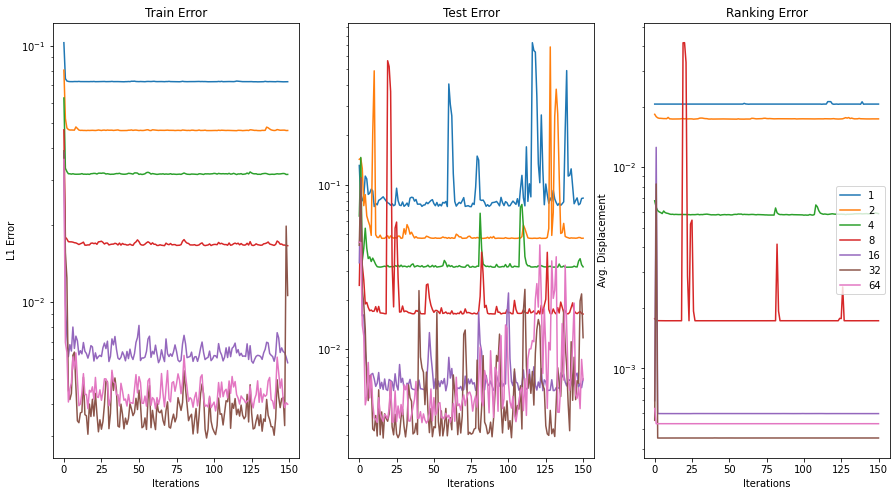

In [8]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
for idx,k in enumerate([1,2,4,8,16,32,64]):
    plt.semilogy(graph_results[idx][0])
plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
for idx,k in enumerate([1,2,4,8,16,32,64]):
    plt.semilogy(graph_results[idx][1])
plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
for idx,k in enumerate([1,2,4,8,16,32,64]):
    plt.semilogy(graph_results[idx][2],label=k)
plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.show()

Test loss and rank displacement are similar to GraphConv models of similar depth. Convergence is nigh-instantaneous (owing to the small parameter count); since we do not have to backpropagate through the aggreations, SGC also takes a third of the time to train.

In [10]:
best_table.append([np.min(graph_results[idx][1]) for idx in range(7)])

## PolynomialSGC

If matrix $A$ has eigenpairs $(\lambda_{i},v_{i})$, $p(A)$ (for some polynomial $p$) possesses eigenpairs $(p(\lambda_{i}),v_{i})$. SGC uses $p(A) = A^{k}$, as all except the final matrix power are discarded. But it is often possible to choose a more efficient polynomial, in the sense that $\frac{|p(\lambda_{2})|}{|p(\lambda_{1})|}\leq{}(\frac{|\lambda_{2}|}{|\lambda_{1}|})^{k}$. To this end, we propose an extension of SGC, PolynomialSGC:

$$X^{out} = \Theta{}(\frac{c_{k}A^{k}X^{in} + c_{k-1}A^{k-1}X^{in} + ... + c_{0}X^{in}}{||c_{k}A^{k}X^{in} + c_{k-1}A^{k-1}X^{in} + ... + c_{0}X^{in}||_{2}})$$


where $|c_{i}|\leq{}1$ for all $i=0,1,2,...,k$

In [19]:
class PolynomialSGC(torch.nn.Module):
    def __init__(self,in_channels,int_channels,out_channels,k=2):
        super(PolynomialSGC,self).__init__()
        self.coefficients = torch.nn.Parameter(torch.randn(k+1))
        self.finish = torch.nn.Sequential(*[torch.nn.Linear(1,int_channels),torch.nn.LeakyReLU(),torch_geometric.nn.BatchNorm(int_channels),
                                            torch.nn.Linear(int_channels,int_channels),torch.nn.LeakyReLU(),torch_geometric.nn.BatchNorm(int_channels),
                                            torch.nn.Linear(int_channels,int_channels),torch.nn.LeakyReLU(),torch_geometric.nn.BatchNorm(int_channels),
                                            torch.nn.Linear(int_channels,out_channels)])
        self.k = k

    def forward(self,X,edge_index,edge_weight,batch):
        X = X/torch_scatter.scatter_sum(X**2,batch,dim=0).sqrt()[batch]
        coeffs = torch.tanh(self.coefficients)

        Z = coeffs[0] * X
        for idx in range(self.k):
            X = torch_scatter.scatter_sum(edge_weight[:,None] * X[edge_index[1]],edge_index[0],dim=0)
            X = X/torch_scatter.scatter_sum(X**2,batch,dim=0).sqrt()[batch]
            Z = Z + coeffs[idx+1] * X
        Z = Z/torch_scatter.scatter_sum(Z**2,batch,dim=0).sqrt()[batch]
        return self.finish(Z)

In [20]:
results = []

torch.manual_seed(0)
for k in [1,2,4,8,16,32,64]:
    model = PolynomialSGC(1,32,1,k).cuda()
    
    results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
    torch.cuda.empty_cache()

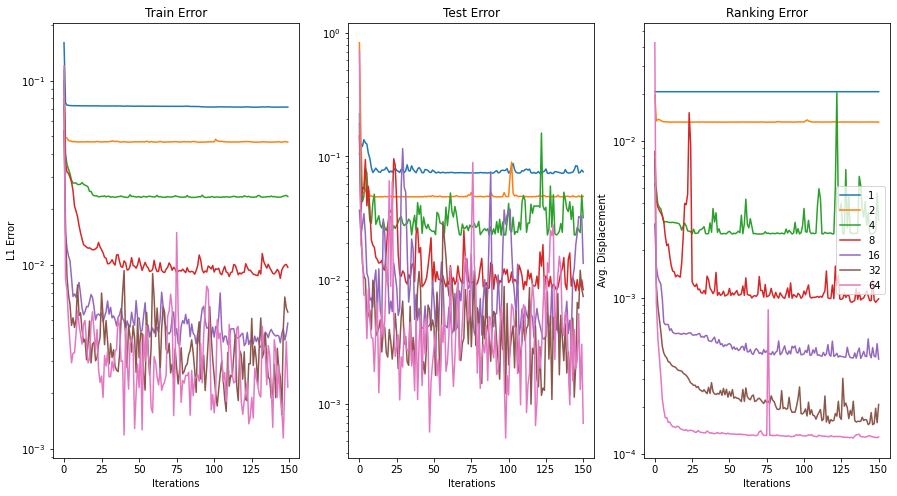

In [22]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
for idx,k in enumerate([1,2,4,8,16,32,64]):
    plt.semilogy(results[idx][0])
plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
for idx,k in enumerate([1,2,4,8,16,32,64]):
    plt.semilogy(results[idx][1])
plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
for idx,k in enumerate([1,2,4,8,16,32,64]):
    plt.semilogy(results[idx][2],label=k)
plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.show()

Train and test loss are slightly improved from base SGC, albeit much more erratic. Rank displacement benefits the most, and change is especially notable in the $l_{max}=64$ case.

In [23]:
best_table.append([np.min(results[idx][1]) for idx in range(7)])

## MixHop

We also examine a single-layer MixHop model as introduced in El-Haija et. al. (2019). Taking similar inspiration from SGC, MixHop concatenates each level of aggreation into a single feature vector [18]. 
$$X^{out} = \Theta{}(A^{k}X^{in} || A^{k-1}X^{in} || ... || X^{in})$$


In [24]:
class MixHop(torch.nn.Module):
    def __init__(self,in_channels,int_channels,out_channels,k=2):
        super(MixHop,self).__init__()
        self.finish = torch.nn.Sequential(*[torch.nn.Linear(k+1,int_channels),torch.nn.LeakyReLU(),torch_geometric.nn.BatchNorm(int_channels),
                                            torch.nn.Linear(int_channels,int_channels),torch.nn.LeakyReLU(),torch_geometric.nn.BatchNorm(int_channels),
                                            torch.nn.Linear(int_channels,int_channels),torch.nn.LeakyReLU(),torch_geometric.nn.BatchNorm(int_channels),
                                            torch.nn.Linear(int_channels,out_channels)])
        self.k = k

    def forward(self,X,edge_index,edge_weight,batch):
        X = X/torch_scatter.scatter_sum(X**2,batch,dim=0).sqrt()[batch]
        Z = X
        for idx in range(self.k):
              X = torch_scatter.scatter_sum(edge_weight[:,None] * X[edge_index[1]],edge_index[0],dim=0)
              X = X/torch_scatter.scatter_sum(X**2,batch,dim=0).sqrt()[batch]
              Z = torch.cat((Z,X),dim=1)
        return self.finish(Z)

In [25]:
results = []

torch.manual_seed(0)
for k in [1,2,4,8,16,32,64]:
    model = MixHop(1,32,1,k).cuda()
    
    results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
    torch.cuda.empty_cache()

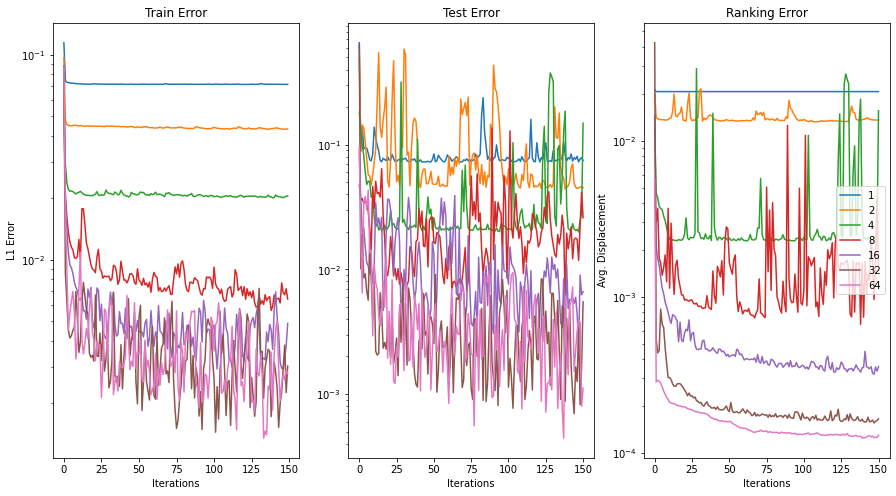

In [26]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
for idx,k in enumerate([1,2,4,8,16,32,64]):
    plt.semilogy(results[idx][0])
plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
for idx,k in enumerate([1,2,4,8,16,32,64]):
    plt.semilogy(results[idx][1])
plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
for idx,k in enumerate([1,2,4,8,16,32,64]):
    plt.semilogy(results[idx][2],label=k)
plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.show()

Performance is on par with PolynomialSGC (if marginally better); however, the convergence of test error and rank displacement for small $l_{max}$ is much less stable.

In [27]:
best_table.append([np.min(results[idx][1]) for idx in range(7)])

## Overview

In [31]:
import pandas as pd

table = pd.DataFrame(best_table)
table.columns = [1,2,4,8,16,32,64]
table.index = ['SGC','PolynomialSGC','MixHop']
table

,1,2,4,8,16,32,64
SGC,0.073393,0.047096,0.031478,0.016355,0.005591,0.002888,0.003560
PolynomialSGC,0.072811,0.047049,0.023054,0.008184,0.003300,0.000991,0.000527
MixHop,0.072571,0.044288,0.019939,0.005585,0.002339,0.000697,0.000444


Both PolynomialSGC and MixHop offer improvement over base SGC, with the latter providing the lowest minimum test loss across the board. In future, we would like to do some proper analysis; we're particularily interested in how the eigenvalue ratio may change during training. 